In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/train.csv.zip').set_index('timestamp')

In [50]:
btc = data[data["Asset_ID"]==1]

btc_mini = btc.iloc[-200:] 

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, 
                                     open=btc_mini['Open'], 
                                     high=btc_mini['High'], 
                                     low=btc_mini['Low'], 
                                     close=btc_mini['Close'])])
fig.show()


In [52]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [85]:
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

In [56]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [73]:
def totimestamp(date): 
  return datetime.strptime(date, '%d/%m/%Y').timestamp()

In [74]:
btc_mini_2021 = btc.loc[totimestamp('01/01/2021'):totimestamp('01/02/2021')]
return_btc = log_return(btc_mini_2021.Close)[1:]

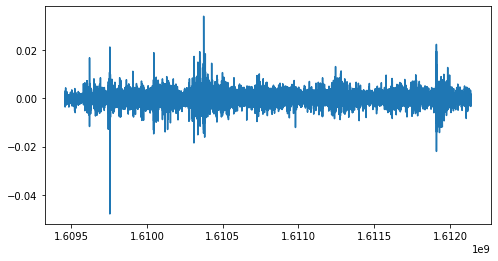

In [86]:
plt.figure(figsize=(8,4))
plt.plot(return_btc);
plt.show()

In [76]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), 
                   log_return(btc.VWAP,periods=1).abs(), 
                   upper_shadow(btc), 
                   lower_shadow(btc)], axis=1)

y_btc = btc.Target


In [79]:
train_window = [totimestamp("01/01/2018"), totimestamp("01/02/2018")]
test_window = [totimestamp("01/02/2018"), totimestamp("01/03/2018")]

X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

In [82]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

In [84]:
print('Test score for LR: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}")

Test score for LR baseline: BTC 0.17
